# Clustering lynx

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

from tqdm import tqdm
from torchvision import models
from scipy.stats import norm
from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors
from oml.functional.metrics import calc_cmc, calc_map, calc_precision

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/gpfs7kro/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blo

In [3]:
random.seed(42)

In [4]:
# !pip install -U open-metric-learning --user --no-cache-dir
# !pip install gensim --user --no-cache-dir

## Load data

In [5]:
data = pd.read_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv")
data

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-04-27,NaN,1,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-05-05,NaN,2,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-17,NaN,3,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-16,NaN,4,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-05,NaN,5,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...,...,...,...
3075,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,2,0.925,668.7360,1152.9216,3805.5744,2295.8208
3076,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3,0.949,1276.8192,880.9344,3906.6624,2475.8784
3077,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4,0.902,615.8804,767.9859,1334.8447,828.8511
3078,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,1,0.959,1797.7904,835.8592,470.8928,251.9680


### Load our best model to get embeddings from image

In [6]:
model_weights = torch.load("/gpfswork/rech/ads/commun/kg_tests/model_best_0.512.pth", map_location=torch.device('cpu'))
model = models.resnet50(pretrained=False)
model.fc = nn.Identity()
model.load_state_dict(model_weights)

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [7]:
# load dataset

from lynx_id.data.triplets import LynxDataset, BalancedBatchSampler
from pathlib import Path
from lynx_id.data.transformations_and_augmentations import transforms

lynxDataset = LynxDataset(dataset_csv=Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv"), 
                      loader="pil",
                      transform=transforms,  # Define 'preprocess' earlier in your script
                      augmentation=None,
                      mode='single',
                      device="auto")

torch.Size([3, 224, 224])


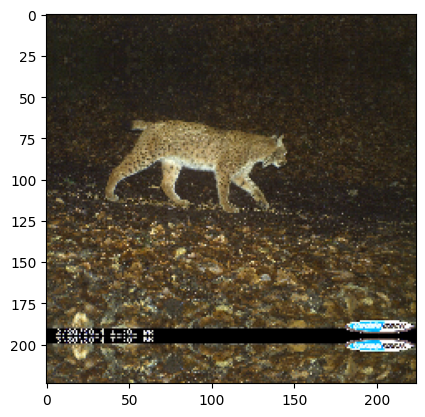

In [8]:
img = lynxDataset[900][0]['image']
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

### Selection of individuals

We are looking for individuals with around 10 images to test the evaluation metrics.

In [9]:
lynx_id_counts = data['lynx_id'].value_counts()
lynx_id_counts[0:40]

F39-060                    245
F39-054                     75
163                         74
F39-095=1556                69
F25-008                     61
F39-061                     57
F25-067=1376                55
F01-053=997                 54
F25-022=B285                53
F01-047=922                 51
F39-086=1474=1478           49
F39-093=2217=2218           49
F25-063=1239=1240=B683      48
F39-038                     42
F39-036                     41
F01-011=933                 41
F25-055=1019=1377=R298      40
F39-098=J1-2019-F39-059     39
F01-007                     38
F39-063                     37
1350=B2011-57               36
ARCOS=629                   36
OSLO=1417                   35
F01-020                     34
F39-045                     31
F73-005=2085=2098           29
403                         28
F39-065                     27
F25-019                     25
409                         25
2001-67-FIFO                25
1764                        25
1376    

In [10]:
lynx_id_counts[70:100].index.tolist()

['F25-039',
 '1277',
 'F25-053=1247',
 '1276=1278',
 '1528=B811',
 '777',
 '2620',
 '1567',
 'F39-043',
 '1317',
 'F01-021',
 'F25-033',
 'F74-003',
 '1321',
 '243',
 'F01-008',
 '1068',
 'F39-025',
 'F01-031',
 'Leki',
 'F25-062=1050=1102=B704',
 '1813',
 '1320',
 '1759',
 '2658',
 '2166',
 '1942',
 '1254',
 'Bingo',
 '2350']

In [11]:
selected_individuals = ["Leki", "1068", "243"]

In [12]:
data_selected_individuals = data[data["lynx_id"].isin(selected_individuals)]
data_selected_individuals = data_selected_individuals.copy()

In [13]:
# add an "unknown" candidate
new_individual = data.iloc[900].copy()
new_individual['lynx_id'] = "New"
data_selected_individuals = pd.concat([data_selected_individuals, new_individual.to_frame().T])

In [14]:
print(data_selected_individuals.shape)
data_selected_individuals

(28, 12)


,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
23,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,NaN,NaN,1,0.866,447.951,137.9448,382.93,357.9996
24,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-09-27,NaN,2,0.926,765.0,442.8996,413.85,275.9445
25,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-10-16,NaN,3,0.951,824.85,378.9555,235.95,158.928
26,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-04-15,NaN,4,0.968,516.8448,988.8,791.856,625.0
27,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2022-09-05,NaN,5,0.924,821.8624,408.924,268.9024,149.9388
28,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-11-25,NaN,6,0.94,288.9576,335.9232,433.9992,320.976
29,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2015-02-14,NaN,7,0.92,639.9,173.9484,326.85,379.9688
30,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,NaN,NaN,8,0.952,733.0,233.9571,267.875,411.9663
31,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,NaN,NaN,9,0.931,462.8952,150.9624,340.9844,386.9586
695,/gpfsscratch/rech/ads/commun/datasets/extracte...,1068,OFB,OCELLES,2017-09-28,La-Tour-du-Meix,1,0.967,405.9776,119.99232,1122.8784,1054.8928


In [15]:
indices_lynxDataset = data_selected_individuals.index.tolist()

In [16]:
# Compute batch
images = []
for individual_index in indices_lynxDataset:
    img = lynxDataset[individual_index][0]['image'].type(torch.FloatTensor)

    images.append(img)
    
images = torch.stack(images, dim=0)
images.shape

torch.Size([28, 3, 224, 224])

### Compute all embeddings

In [17]:
with torch.no_grad():
    embeddings = model(images)
    
embeddings.shape

torch.Size([28, 2048])

In [18]:
embeddings

tensor([[0.1397, 0.2340, 0.1894,  ..., 0.1131, 0.1719, 0.1199],
        [0.2006, 0.2310, 0.1828,  ..., 0.1039, 0.1809, 0.1493],
        [0.2077, 0.2394, 0.1747,  ..., 0.0995, 0.1891, 0.1488],
        ...,
        [0.2095, 0.2318, 0.1750,  ..., 0.1123, 0.1519, 0.2438],
        [0.2172, 0.2253, 0.1724,  ..., 0.1158, 0.1513, 0.2586],
        [0.2197, 0.2240, 0.1849,  ..., 0.0983, 0.1511, 0.2434]])

### Dimension reduction and choice of candidates

In [19]:
lynx_str_to_int = {}
lynx_int_to_str = {}

for index, string in enumerate(selected_individuals):
    lynx_str_to_int[string] = index
    lynx_int_to_str[index] = string
    
print(lynx_str_to_int)
print(lynx_int_to_str)

{'Leki': 0, '1068': 1, '243': 2}
{0: 'Leki', 1: '1068', 2: '243'}


In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10)
embeddings_2d = tsne.fit_transform(embeddings)

print(embeddings_2d.shape)

(28, 2)


In [21]:
if 'level_0' in data_selected_individuals.columns:
    data_selected_individuals.drop(['level_0'], axis=1, inplace=True)
data_selected_individuals.reset_index(inplace=True)
data_selected_individuals['embedding'] = list(map(list, embeddings_2d))
data_selected_individuals[['embedding_x', 'embedding_y']] = pd.DataFrame(embeddings_2d)
data_selected_individuals['lynx_id_int'], _ = pd.factorize(data_selected_individuals["lynx_id"])

In [22]:
def extract_random_rows(group, nb_to_extract=2):
    if group.shape[0] < nb_to_extract:
        return group
    return group.sample(n=nb_to_extract, replace=False)


data_candidates = data_selected_individuals.groupby('lynx_id', group_keys=False).apply(extract_random_rows)

indices_to_remove = data_candidates.index
data_knowledge = data_selected_individuals.drop(indices_to_remove)

In [23]:
embeddings_2d_candidates = embeddings_2d[data_candidates.index]
embeddings_2d_knowledge = embeddings_2d[data_knowledge.index]

print(embeddings_2d_candidates.shape, embeddings_2d_knowledge.shape)

(7, 2) (21, 2)


In [24]:
embeddings_candidates = embeddings[data_candidates.index]
embeddings_knowledge = embeddings[data_knowledge.index]

print(embeddings_candidates.shape, embeddings_knowledge.shape)

torch.Size([7, 2048]) torch.Size([21, 2048])


### Viewing individuals with their embeddings

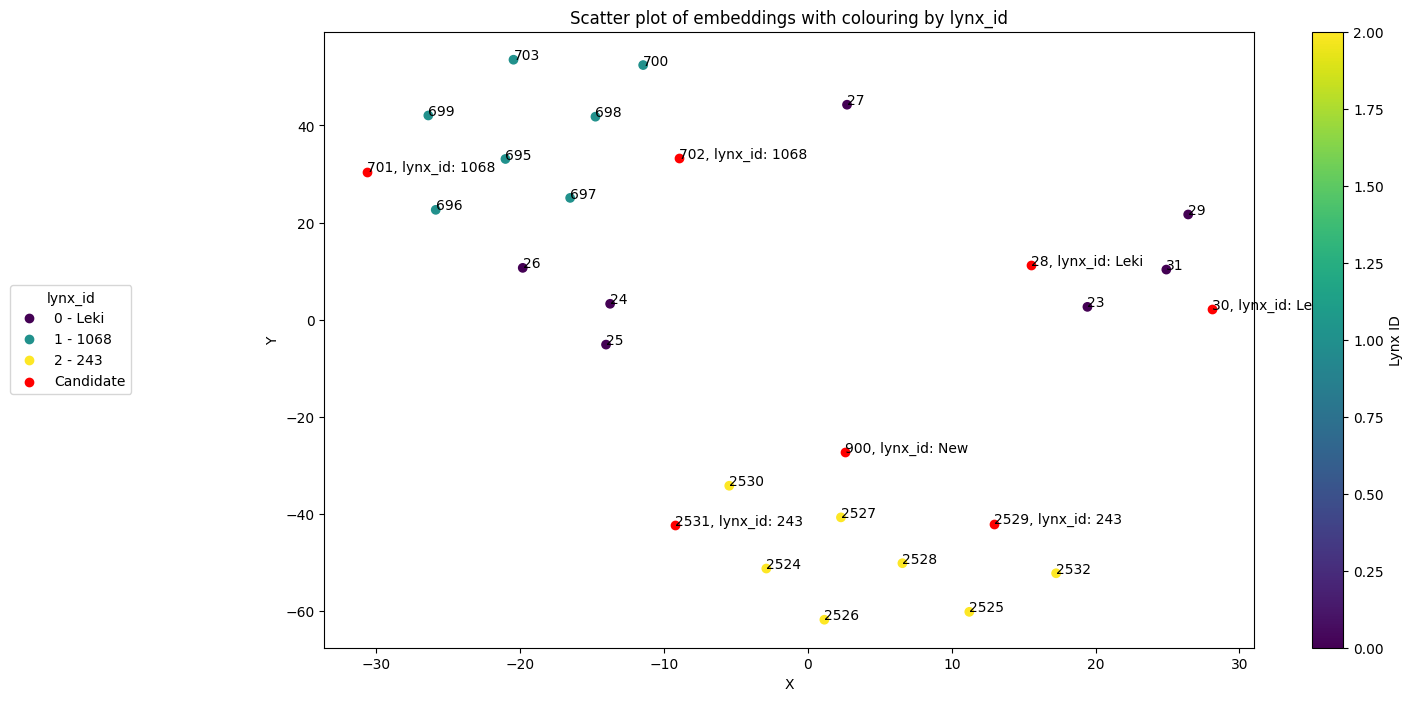

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = plt.scatter(data_knowledge['embedding_x'], data_knowledge['embedding_y'], c=data_knowledge['lynx_id_int'])
ax.scatter(data_candidates['embedding_x'], data_candidates['embedding_y'], c='red', marker='o', label='New data')

handles, labels = scatter.legend_elements()
handles.append(ax.scatter([], [], c='red', marker='o'))
labels.append('Candidate')

for i in data_knowledge.index.tolist():
    plt.annotate(data_knowledge.loc[i]['index'], (embeddings_2d[i, 0], embeddings_2d[i, 1]))

for i in data_candidates.index.tolist():
    plt.annotate(str(data_candidates.loc[i]['index']) + ", lynx_id: " + data_candidates.loc[i]['lynx_id'], (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    
labels = [re.search(r'\d+', key).group() + ' - ' + lynx_int_to_str[int(re.search(r'\d+', key).group())] if re.search(r'\d+', key) else key for key in labels]
legend = ax.legend(handles, labels, loc="center right", title="lynx_id",  bbox_to_anchor=(-0.2, 0.5))

plt.colorbar(label="Lynx ID")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter plot of embeddings with colouring by lynx_id")
plt.savefig("embeddings.png")

### Nearest Neighbors

Computation with real embeddings, no t-SNE

In [26]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric="minkowski").fit(embeddings_knowledge)

In [27]:
distances, indices = neighbors.kneighbors(embeddings_candidates)
distances, indices

(array([[0.91005877, 1.2168678 , 1.32553274, 1.46153753, 1.51055966],
        [0.20634871, 0.3016534 , 0.47443368, 1.24142927, 1.28307385],
        [0.45372473, 0.52840971, 0.74862429, 0.7977677 , 0.81830602],
        [0.28593807, 0.6711093 , 1.06785094, 1.18862897, 1.51765895],
        [1.17487703, 1.24579299, 2.57083931, 2.64465142, 2.6754004 ],
        [0.68720807, 0.87489996, 2.57011408, 2.58517519, 2.60503341],
        [1.30812187, 1.38181226, 1.61003359, 1.73378407, 1.76397412]]),
 array([[11, 10,  7,  9,  8],
        [ 8,  9,  7, 10, 11],
        [18, 14, 17, 20, 15],
        [19, 17, 14, 18, 20],
        [ 0,  6,  1,  4,  5],
        [ 0,  6, 19,  2,  1],
        [19, 17, 14, 18,  1]]))

In [28]:
candidates_nearest_neighbors = [
    data_knowledge.iloc[candidate_indices]["lynx_id"]
    for candidate_indices in indices
]

candidates_nearest_neighbors

[13    1068
 12    1068
 9     1068
 11    1068
 10    1068
 Name: lynx_id, dtype: object,
 10    1068
 11    1068
 9     1068
 12    1068
 13    1068
 Name: lynx_id, dtype: object,
 22    243
 18    243
 21    243
 26    243
 19    243
 Name: lynx_id, dtype: object,
 24    243
 21    243
 18    243
 22    243
 26    243
 Name: lynx_id, dtype: object,
 0    Leki
 8    Leki
 1    Leki
 4    Leki
 6    Leki
 Name: lynx_id, dtype: object,
 0     Leki
 8     Leki
 24     243
 2     Leki
 1     Leki
 Name: lynx_id, dtype: object,
 24     243
 21     243
 18     243
 22     243
 1     Leki
 Name: lynx_id, dtype: object]

In [29]:
candidates_predicted_n_knn = [
    candidate.value_counts().idxmax() for candidate in candidates_nearest_neighbors
]

candidates_predicted_n_knn

['1068', '1068', '243', '243', 'Leki', 'Leki', '243']

In [30]:
candidates_predicted_1_knn = [
    candidate.iloc[0] for candidate in candidates_nearest_neighbors
]

candidates_predicted_1_knn

['1068', '1068', '243', '243', 'Leki', 'Leki', '243']

In [31]:
# True lynx_id
candidates_id = data_candidates.lynx_id.tolist()
candidates_id

['1068', '1068', '243', '243', 'Leki', 'Leki', 'New']

#### Should we reject the individual prediction? Is it a new individual?

In [32]:
cluster_variances = {cluster_indices: np.var(data_knowledge[data_knowledge['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_variances

{0: array([341.18384, 228.06982], dtype=float32),
 1: array([ 26.760538, 129.44386 ], dtype=float32),
 2: array([54.571236, 83.63348 ], dtype=float32)}

In [33]:
cluster_means = {cluster_indices: np.mean(data_knowledge[data_knowledge['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_means

{0: array([ 3.6988277, 12.511506 ], dtype=float32),
 1: array([-19.50355,  38.65882], dtype=float32),
 2: array([  4.303224, -50.1239  ], dtype=float32)}

To **find the best value for sigma**, we can try to **find the value which maximises the true positives (rate of well classified known individuals) and the true negatives (rate of well classified unknown individuals)**.

In [34]:
confidence_levels = [0.68, 0.95, 0.99]

In [35]:
def compute_confidence_intervals(confidence, means, variances):
    intervals = []
    for mean, variance in zip(means.values(), variances.values()):
        interval = norm.interval(confidence, loc=mean, scale=np.sqrt(variance))
        intervals.append((np.array([interval[0][0], interval[1][0]]), np.array([interval[0][1], interval[1][1]])))
    
    return intervals

In [36]:
def check_new_individual(candidates_dots, candidates_predicted, candidates_id):
    candidates_predicted_local = candidates_predicted.copy()
    for index, (candidate_dot, candidate_predicted, candidate_id) in enumerate(zip(candidates_dots, candidates_predicted, candidates_id)):
        confidence_intervals_for_candidate = confidence_intervals[lynx_str_to_int[candidate_predicted]]

        in_confidence_interval = all(
            interval[0] <= dot <= interval[1]
            for dot, interval in zip(candidate_dot, confidence_intervals_for_candidate)
        )

        if in_confidence_interval:
            print(f"Candidate {candidate_dot} | Prediction: {candidate_predicted} | True label: {candidate_id}")
        else:
            print(f"Candidate {candidate_dot} | Prediction: new individual | True label: {candidate_id}")
            candidates_predicted_local[index] = "New"
        
    return candidates_predicted_local

In [37]:
def compute_accuracy(candidates_predicted, candidates_refs):
    correct_predictions = sum(p == r for p, r in zip(candidates_predicted, candidates_refs))

    total_predictions = len(candidates_predicted)
    accuracy = correct_predictions/total_predictions
    
    return accuracy

In [38]:
candidates_dots = data_candidates.embedding.tolist()
candidates_dots

[[-8.930031, 33.1954],
 [-30.683247, 30.482872],
 [12.915244, -42.053444],
 [-9.216347, -42.34407],
 [15.530349, 11.188709],
 [28.096394, 2.099799],
 [2.5757048, -27.358734]]

In [39]:
accuracy_list = []

for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    confidence_intervals = compute_confidence_intervals(confidence, cluster_means, cluster_variances)
    candidates_predicted_check = check_new_individual(candidates_dots, candidates_predicted_1_knn, candidates_id)
    accuracy = compute_accuracy(candidates_predicted_check, candidates_id)
    print(f"Accuracy: {accuracy}")
    accuracy_list.append(accuracy)

************************************************** 0.68 **************************************************
Candidate [-8.930031, 33.1954] | Prediction: new individual | True label: 1068
Candidate [-30.683247, 30.482872] | Prediction: new individual | True label: 1068
Candidate [12.915244, -42.053444] | Prediction: new individual | True label: 243
Candidate [-9.216347, -42.34407] | Prediction: new individual | True label: 243
Candidate [15.530349, 11.188709] | Prediction: Leki | True label: Leki
Candidate [28.096394, 2.099799] | Prediction: new individual | True label: Leki
Candidate [2.5757048, -27.358734] | Prediction: new individual | True label: New
Accuracy: 0.2857142857142857
************************************************** 0.95 **************************************************
Candidate [-8.930031, 33.1954] | Prediction: new individual | True label: 1068
Candidate [-30.683247, 30.482872] | Prediction: new individual | True label: 1068
Candidate [12.915244, -42.053444] | Predic

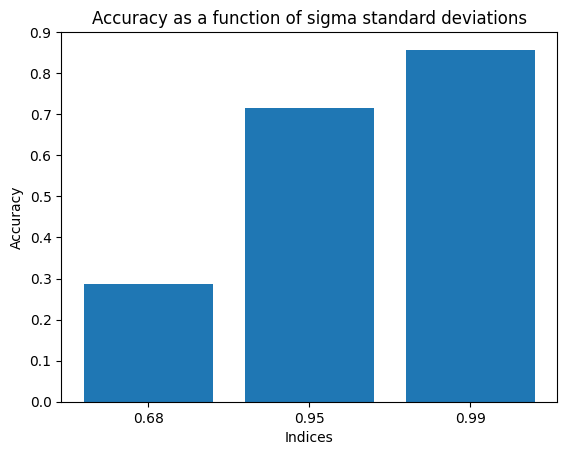

In [40]:
plt.bar([str(conf) for conf in confidence_levels], accuracy_list)
plt.xlabel('Indices')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of sigma standard deviations')
plt.show()

### Compute the other metrics

Now let's calculate the metrics. To do this, we use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k**, **mAP@k** and **Precision@k**. 

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as New, will see its neighbours as "New" from now on.

In [41]:
for index, value in enumerate(candidates_predicted_check):
    if value == "New":
        candidates_nearest_neighbors[index] = candidates_nearest_neighbors[index].apply(lambda x: "New")
        
candidates_nearest_neighbors

[13    1068
 12    1068
 9     1068
 11    1068
 10    1068
 Name: lynx_id, dtype: object,
 10    1068
 11    1068
 9     1068
 12    1068
 13    1068
 Name: lynx_id, dtype: object,
 22    243
 18    243
 21    243
 26    243
 19    243
 Name: lynx_id, dtype: object,
 24    243
 21    243
 18    243
 22    243
 26    243
 Name: lynx_id, dtype: object,
 0    Leki
 8    Leki
 1    Leki
 4    Leki
 6    Leki
 Name: lynx_id, dtype: object,
 0     Leki
 8     Leki
 24     243
 2     Leki
 1     Leki
 Name: lynx_id, dtype: object,
 24     243
 21     243
 18     243
 22     243
 1     Leki
 Name: lynx_id, dtype: object]

In [42]:
top_k = (1, 2, 3, 4, 5)

In [43]:
def acc_k_list(nearest_individuals, true_individual):
    return nearest_individuals.apply(lambda x: x == true_individual).tolist()

In [44]:
candidates_acc_k_list = [acc_k_list(neighbors, candidate_id) for neighbors, candidate_id in zip(candidates_nearest_neighbors, candidates_id)]
candidates_acc_k_tensor = torch.tensor(candidates_acc_k_list, dtype=torch.bool)

candidates_acc_k_tensor

tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True],
        [False, False, False, False, False]])

In [45]:
def compute_mean_per_top_k(metric_output):
    metric_mean = torch.mean(torch.stack(metric_output), dim=1)
    return {k: v.item() for k, v in zip(top_k, metric_mean)}

#### CMC@k (Cumulative Matching Characteristics) 

In [46]:
cmc_k = calc_cmc(candidates_acc_k_tensor, top_k)
cmc_k

[tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0.])]

In [47]:
compute_mean_per_top_k(cmc_k)

{1: 0.8571428656578064,
 2: 0.8571428656578064,
 3: 0.8571428656578064,
 4: 0.8571428656578064,
 5: 0.8571428656578064}

#### mAP@k (mean Average Precision)

In [48]:
n_gt = torch.tensor([5])

In [49]:
map_k = calc_map(candidates_acc_k_tensor, n_gt=n_gt, top_k=top_k)
map_k

[tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9167, 0.0000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8875, 0.0000])]

In [50]:
compute_mean_per_top_k(map_k)

{1: 0.8571428656578064,
 2: 0.8571428656578064,
 3: 0.8571428656578064,
 4: 0.8452381491661072,
 5: 0.8410714268684387}

#### Precision@k

In [51]:
precision_k = calc_precision(candidates_acc_k_tensor, n_gt=n_gt, top_k=top_k)
precision_k

[tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0.]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.0000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7500, 0.0000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 0.0000])]

In [52]:
compute_mean_per_top_k(precision_k)

{1: 0.8571428656578064,
 2: 0.8571428656578064,
 3: 0.80952388048172,
 4: 0.8214285969734192,
 5: 0.8285714387893677}